In [1]:
sampleSizes = carData.groupby(by=['make', 'model']).count()['mileage']
sampleSizes = sampleSizes.rename('sample_size')
def printSize(sampleSizes, make, model):
    sampleSize = sampleSizes[make][model]
    print('Train Size: {}'.format(sampleSize*0.7))
    print('CV Train Size: {}'.format(sampleSize*0.7*0.8))
    print('CV Test Size: {}'.format(sampleSize*0.7*0.2))
    print('Test Size: {}'.format(sampleSize*0.3))
    
ridgeTest = ridgeTest.merge(right= sampleSizes.reset_index(), left_on = ['make', 'model'], right_on = ['make', 'model'])
printSize(sampleSizes, 'Opel', 'Grandland X')

NameError: name 'carData' is not defined

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from sklearn.metrics import mean_squared_error

from math import log
from numpy import random
from datetime import date

In [37]:
path = Path.cwd()
path = path.joinpath('Models')

modelPaths = list(path.glob('*'))

testResults = pd.DataFrame()
CVResults = pd.DataFrame()
regressorCoeffs = pd.DataFrame()
CFGS = {}
for modelPath in modelPaths:
    folder = modelPath.stem
    components = modelPath.stem.split('_')

    if len(components)==3:
        regressor = components[0]
        estimator = components[1]
        ts = components[2]

        testPath = modelPath.joinpath('testResults.csv')
        testResult = pd.read_csv(str(testPath))
        testResult['architecture'] = regressor+estimator
        testResult['ts'] = ts
        testResult['folder'] = folder

        CVPath = modelPath.joinpath('CV.csv')
        CVResult = pd.read_csv(str(CVPath))
        CVResult['architecture'] = regressor+estimator
        CVResult['ts'] = ts
        CVResult['folder'] = folder
        
        regressorCoeffPath = modelPath.joinpath('regressorCoeff.csv')
        
        if regressorCoeffPath.exists():
            regressorCoeff = pd.read_csv(str(regressorCoeffPath))
            regressorCoeff['architecture'] = regressor+estimator
            regressorCoeff['ts'] = ts
            regressorCoeff['folder'] = folder
            if len(regressorCoeffs)==0:
                regressorCoeffs=regressorCoeff.copy()
            else:
                regressorCoeffs=pd.concat([regressorCoeffs,regressorCoeff])
                
        CFGPath = modelPath.joinpath('CFG.txt')
        CFG = {}
        with CFGPath.open() as f:
            CFG = json.loads(f.read())
        CFGS[folder] = CFG

        if len(testResults)==0:
            testResults = testResult.copy()
            CVResults = CVResult.copy()
        else:
            testResults = pd.concat([testResults, testResult])
            CVResults = pd.concat([CVResults, CVResult])
        
        data = []
        for folder in testResults['folder'].unique():
            testResult = testResults[testResults['folder']==folder]
            ts = testResult['ts'].max()
            for alpha in testResult['alpha_value'].unique():
                alphaTestResult = testResult[testResult['alpha_value'] == alpha]
                alphaTestMSE = mean_squared_error(alphaTestResult['true'], alphaTestResult['predict'])
                alphaTrainMSE = alphaTestResult['trainScore'].max()
                data.append([folder, ts, alpha, alphaTestMSE, alphaTrainMSE])

        summary = pd.DataFrame(data=data, columns=['folder', 'ts', 'alpha', 'test', 'train'])

In [38]:
summary[(summary['ts']>'202209210000')]

,folder,ts,alpha,test,train
115,Lasso_GradientBoostingRegressor_202209210919,202209210919,58,0.104207,0.073515
116,Lasso_GradientBoostingRegressor_202209210925,202209210925,58,0.269830,0.217779
117,Lasso_GradientBoostingRegressor_202209210937,202209210937,58,0.027944,0.009791
118,Lasso_GradientBoostingRegressor_202209210958,202209210958,58,0.040359,0.016778
119,Lasso_GradientBoostingRegressor_202209211004,202209211004,58,0.027111,0.009615
120,Lasso_GradientBoostingRegressor_202209211130,202209211130,58,0.026928,0.009676
121,Lasso_GradientBoostingRegressor_202209211142,202209211142,58,0.027399,0.009793
122,Lasso_GradientBoostingRegressor_202209211306,202209211306,58,0.026614,0.009649
123,Lasso_GradientBoostingRegressor_202209211313,202209211313,58,0.027056,0.009646
124,Lasso_GradientBoostingRegressor_202209211334,202209211334,58,0.026782,0.009793


In [17]:
ts = '202209211004'
summaryView = summary[(summary['ts']==ts)]
testView=testResults[testResults['ts']==ts]
CVResultsView = CVResults[CVResults['ts']==ts]
coeffView = regressorCoeffs[regressorCoeffs['ts']==ts]

<AxesSubplot:xlabel='param_ccp_alpha', ylabel='mean_train_score'>

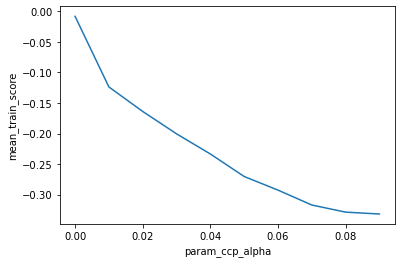

In [129]:
sns.lineplot(data=CVResultsView, x='param_ccp_alpha', y ='mean_train_score')

<AxesSubplot:xlabel='param_ccp_alpha', ylabel='mean_test_score'>

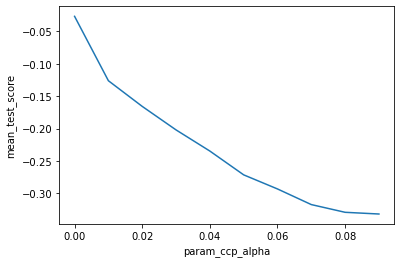

In [130]:
sns.lineplot(data=CVResultsView, x='param_ccp_alpha', y ='mean_test_score')

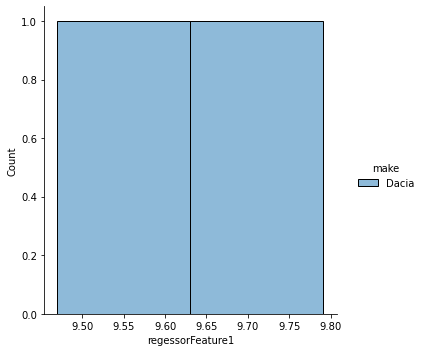

In [28]:
sns.displot(data=coeffView[coeffView['make']=='Dacia'], x='regessorFeature1', hue='make')

In [30]:
coeffView

,Unnamed: 0,regessorFeature0,regessorFeature1,regessorFeature2,make,model,architecture,ts,folder
0,0,-0.0,10.246759,NaN,Opel,Grandland X,LassoGradientBoostingRegressor,202209211004,Lasso_GradientBoostingRegressor_202209211004
1,1,-0.0,10.816762,NaN,Mercedes-benz,GLC Class,LassoGradientBoostingRegressor,202209211004,Lasso_GradientBoostingRegressor_202209211004
2,2,-0.0,10.417085,NaN,Audi,Q3,LassoGradientBoostingRegressor,202209211004,Lasso_GradientBoostingRegressor_202209211004
3,3,-0.0,10.070704,NaN,Ford,Kuga,LassoGradientBoostingRegressor,202209211004,Lasso_GradientBoostingRegressor_202209211004
4,4,-0.0,9.624484,NaN,Peugeot,208,LassoGradientBoostingRegressor,202209211004,Lasso_GradientBoostingRegressor_202209211004
...,...,...,...,...,...,...,...,...,...
116,116,-0.0,10.111922,NaN,Toyota,Rav4,LassoGradientBoostingRegressor,202209211004,Lasso_GradientBoostingRegressor_202209211004
117,117,-0.0,10.226033,NaN,Toyota,C-HR,LassoGradientBoostingRegressor,202209211004,Lasso_GradientBoostingRegressor_202209211004
118,118,-0.0,9.461181,NaN,Peugeot,Partner,LassoGradientBoostingRegressor,202209211004,Lasso_GradientBoostingRegressor_202209211004
119,119,-0.0,10.202051,NaN,Bmw,2 Series,LassoGradientBoostingRegressor,202209211004,Lasso_GradientBoostingRegressor_202209211004
